In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
INTU_csv = Path("../SaaS_Data/Intuit_INTU.csv")

In [3]:
INTU_df = pd.read_csv(INTU_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
INTU_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-08-13,536.36,541.21,534.51,540.74,"541,187"
2021-08-12,532.29,538.14,530.23,536.92,"521,221"
2021-08-11,529.39,533.04,526.62,532.23,"765,098"
2021-08-10,538.23,539.99,528.71,530.13,"855,955"
2021-08-09,534.17,537.24,531.87,535.23,"733,126"


In [5]:
INTU_df.sort_index(ascending=True, inplace=True)

In [6]:
INTU_df = INTU_df.rename(columns={'Close': 'Close'})
INTU_df = INTU_df[['Close']]
INTU_df

,Close
Date,
2020-08-13,306.71
2020-08-14,305.54
2020-08-17,308.01
2020-08-18,308.90
2020-08-19,310.55
...,...
2021-08-09,535.23
2021-08-10,530.13
2021-08-11,532.23


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(INTU_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[306.71 305.54 308.01 308.9  310.55 320.06 322.23 333.12 336.42 342.34
  345.   346.11 345.39 347.18 354.18 339.63 333.11 320.82 328.21 320.39
  315.   318.31 322.47 313.38 307.23 300.13 307.7  317.28 304.93 308.59
  318.5  325.55 323.64 326.21 332.34 321.89 331.36 325.38 334.91 334.99
  341.81 350.93 349.59 345.3  341.97 341.15 335.27 334.51 332.79 331.82
  334.42 328.09 330.27 318.51 325.61 314.68 316.42 324.73 343.   350.96
  352.26 360.14 342.26 352.4  349.51 356.95 357.06 358.75 354.74 361.44
  347.69 343.33 345.2  350.47 354.24 352.02 356.82 355.49 363.7  368.6
  372.19 372.59 364.18 362.5  364.32 365.51 360.43 369.26 380.32 380.11
  375.93 379.97 376.92 381.16 381.12 378.33 375.55 379.85 371.7  368.87]
 [305.54 308.01 308.9  310.55 320.06 322.23 333.12 336.42 342.34 345.
  346.11 345.39 347.18 354.18 339.63 333.11 320.82 328.21 320.39 315.
  318.31 322.47 313.38 307.23 300.13 307.7  317.28 304.93 308.59 318.5
  325.55 323.64 326.21 332.34 321.89 331.36 325.38 3

In [9]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [10]:
y_train

array([[361.  ],
       [368.63],
       [374.46],
       [372.34],
       [365.67],
       [364.96],
       [365.51],
       [371.01],
       [384.95],
       [389.46],
       [381.75],
       [374.85],
       [374.43],
       [374.8 ],
       [363.11],
       [369.95],
       [361.23],
       [373.58],
       [384.11],
       [380.15],
       [392.73],
       [389.38],
       [389.74],
       [391.55],
       [397.29],
       [408.82],
       [413.99],
       [422.26],
       [415.81],
       [415.39],
       [411.35],
       [401.55],
       [399.09],
       [413.18],
       [387.98],
       [390.14],
       [406.41],
       [401.75],
       [388.71],
       [376.33],
       [382.21],
       [370.42],
       [384.58],
       [382.82],
       [399.17],
       [395.95],
       [396.84],
       [395.42],
       [391.72],
       [373.97],
       [381.28],
       [383.02],
       [383.2 ],
       [377.29],
       [372.39],
       [376.58],
       [374.62],
       [373.66],
       [383.06

In [11]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [16]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
1/1 [==============================] - 16s 16s/step - loss: 0.3473
Epoch 2/20
1/1 [==============================] - 0s 420ms/step - loss: 0.2244
Epoch 3/20
1/1 [==============================] - 0s 406ms/step - loss: 0.1217
Epoch 4/20
1/1 [==============================] - 0s 407ms/step - loss: 0.0655
Epoch 5/20
1/1 [==============================] - 0s 411ms/step - loss: 0.1354
Epoch 6/20
1/1 [==============================] - 0s 404ms/step - loss: 0.0883
Epoch 7/20
1/1 [==============================] - 0s 388ms/step - loss: 0.0632
Epoch 8/20
1/1 [==============================] - 0s 417ms/step - loss: 0.0766
Epoch 9/20
1/1 [==============================] - 0s 408ms/step - loss: 0.0872
Epoch 10/20
1/1 [==============================] - 0s 415ms/step - loss: 0.0927
Epoch 11/20
1/1 [==============================] - 0s 425ms/step - loss: 0.0866
Epoch 12/20
1/1 [==============================] - 0s 425ms/step - loss: 0.0754
Epoch 13/20
1/1 [==============================] -

In [17]:
model.evaluate(X_test, y_test, verbose=0)

1.0854897499084473

In [18]:
predicted = model.predict(X_test)

In [19]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [20]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [21]:
INTU_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = INTU_df.index[-len(real_prices): ])

INTU_actual_predicted.head()

,Actual,Predicted
Date,,
2021-05-19,417.43,402.510895
2021-05-20,421.20,402.649750
2021-05-21,435.27,402.993622
2021-05-24,433.43,403.595490
2021-05-25,440.41,404.424072


In [22]:
INTU_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,534.29,444.272461
2021-08-10,535.23,444.655334
2021-08-11,530.13,445.010803
2021-08-12,532.23,445.310272
2021-08-13,536.92,445.558136


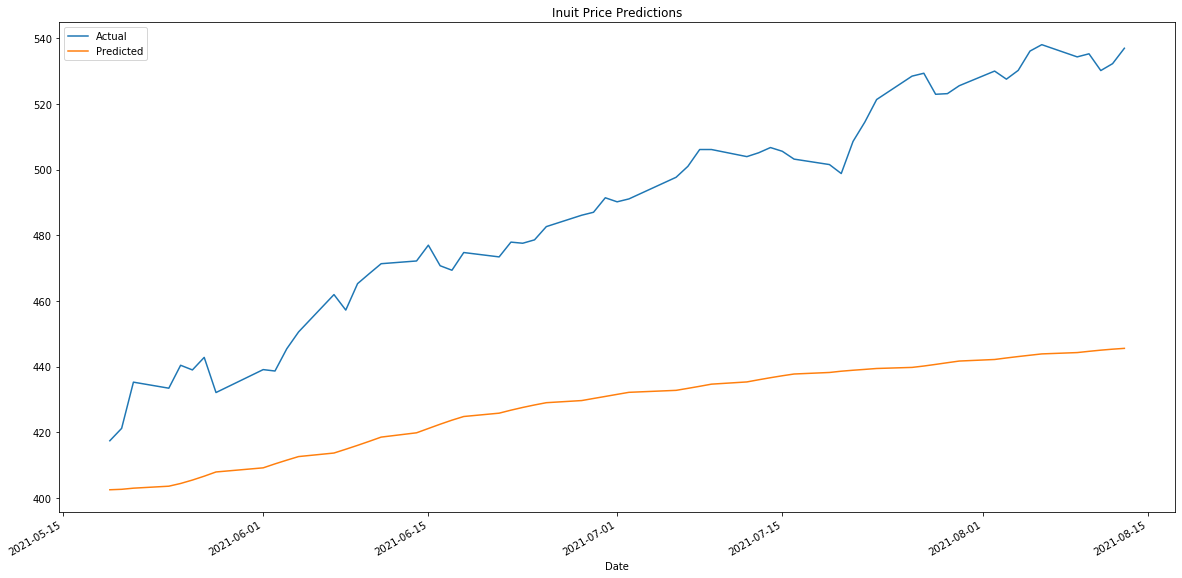

In [23]:
INTU_actual_predicted.plot(figsize=(20,10), title="Inuit Price Predictions")